# CNN + MaxPool
Change the code to use GMM.predict() as threshold.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-14 08:25:52.535018
Python 3.10.0
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM' # 'ZERO' 'THE_MEAN'
BREAK = True   # break after first fold
CACHING = True   # have not worked out how to cache multiple cell lines
NUM_LINES = 1   # 15 to analyze all of them

2023-02-14 08:25:56.020578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

INFO: this run will write sequence to cache.


In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-14 08:26:05.186140
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 


2023-02-14 08:26:05.190702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641,125
Trainable params: 641,125
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        '''Takes list of float, returns list of labels [0,1].'''
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
        else:
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            self.discriminator = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            self.discriminator.fit(rci_values)
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        else:
            self.discriminator = 0
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index)
            self._prepare_threshold(y_rci)  # use train subset only!
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-14 08:26:05.637195
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-14 08:26:20.933191
splitting
Fold 1
FIT
2023-02-14 08:26:27.352243
PREDICT
2023-02-14 08:28:23.597887


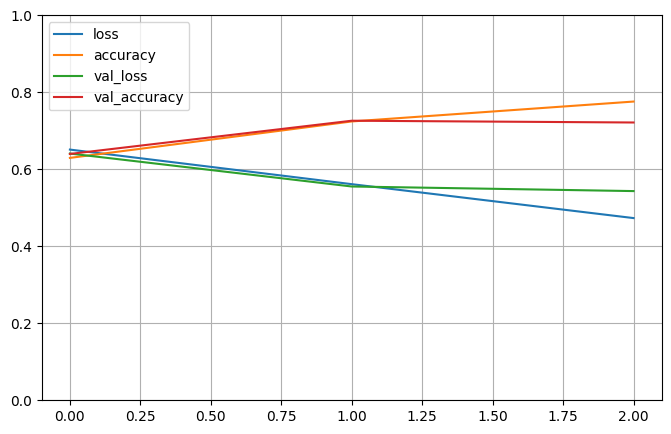

Train set ones/size 2905 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 354 / 869
Range of scores: 0.0062683523 to 0.9804462
Score threshold 0.5
Prediction set ones/size 230 / 869


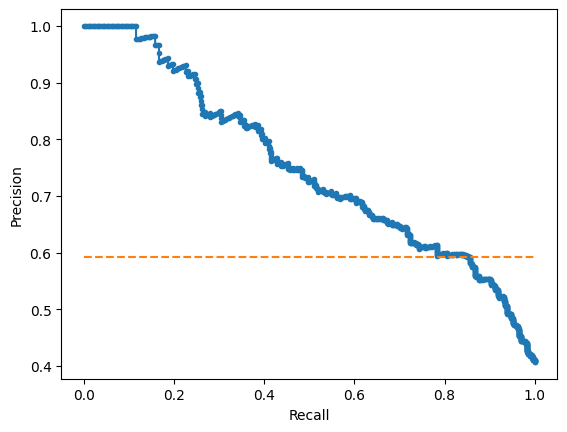

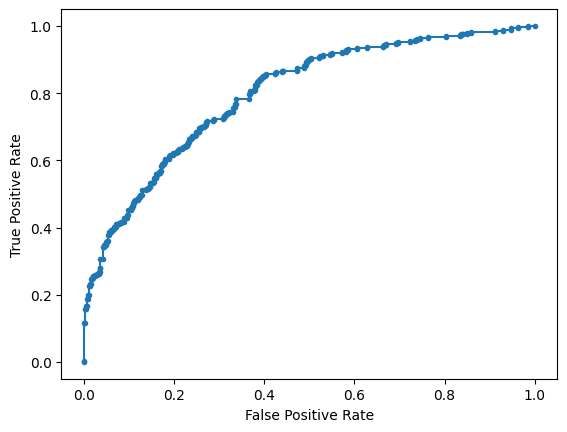

Accuracy: 72.15% Precision: 74.35% Recall: 48.31%
F1: 58.56% AUPRC: 74.91% AUROC: 79.78%
2023-02-14 08:28:25.623898
Break -- this was for code testing only

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.15% +/- nan
 precision mean 74.35% +/- nan
 recall mean 48.31% +/- nan
 F1 mean 58.56% +/- nan
 AUPRC mean 74.91% +/- nan
 AUROC mean 79.78% +/- nan
Finished cell Line 0 A549

2023-02-14 08:28:25.651252


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
for CELL_LINE in range(NUM_LINES):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())